# Learning a sensorimotor model with a context provided by environment

In this notebook, we will see how to use the Explauto libarary to allow the learning and control of actions that depend on a context provided by the environment. We suppose that the reader is familiar with the main components of the Explauto library explained in another notebook ([full tutorial](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/full_tutorial.ipynb)): the environment, the sensorimotor model and the interest model.

Another [tutorial](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/learning_with_sensorimotor_context.ipynb) describes how to define local actions that depends on the previous motor and sensory positions.


In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first define an environment where the sensory feedback depends on the motor command and on the environment's context.
We define a Half Lazy Arm: which is a 2D robotic arm with 3 joints (based on explauto's SimpleArmEnvironment), but with the specificity that it behave normally only one time out of 2, and is lazy (moves much less than commanded) the other times.

In [8]:
from explauto.environment.simple_arm import SimpleArmEnvironment
from explauto.environment import environments

class HalfLazyArm(SimpleArmEnvironment):
    def __init__(self, **kwargs):
        SimpleArmEnvironment.__init__(self, **kwargs)
        self.current_context = [0] # 0: lazy, 1: normal
        
    def compute_motor_command(self, m):
        if self.current_context[0]:
            return m
        else:
            return [mi/4 for mi in m]
        
    def compute_sensori_effect(self, m):
        s = SimpleArmEnvironment.compute_sensori_effect(self, m)        
        self.current_context[0] = 1 - self.current_context[0]
        return s
        
env_cls = HalfLazyArm
env_conf = environments['simple_arm'][1]['low_dimensional']

Here, the context is hidden in self.current_context, and not available to the learning agent. We thus use the "ContextEnvironment" class to translate this HalfLazyArm environment to an environment which is providing the context in the sensory feedback. The sensory feedback is now the concatenation of the context $c$ and the feedback of the arm $s$.
We thus call this mode "mcs".

Additional information has to be provided to build this new environment: "reset_iterations" says the number of iterations before the environment is reset, "context_n_dims" says how many dimensions has the context, and "context_sensory_bounds" specify the min and max bounds on those dimensions.

In [9]:
from explauto.environment.context_environment import ContextEnvironment

context_mode = dict(mode='mcs',
                    reset_iterations=10,
                    context_n_dims=1,
                    context_sensory_bounds=[[0],[1]])

environment = ContextEnvironment(env_cls, env_conf, context_mode)

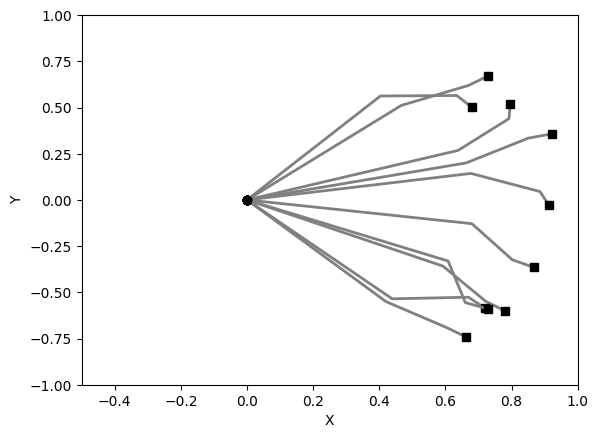

In [10]:
# Create the axes for plotting:
ax = plt.axes()

for m in environment.random_motors(n=10):
    s = environment.update(m, reset=False)
    environment.plot(ax)

Here we detail the learning loop, but this is encapsulated in the "experiment" methods (see after).

Note that to draw a goal given a context, the interest model has to be 'RandomInterest' or 'DiscretizedProgress'.

The RandomInterest model will just draw a random goal in the dimensions of $s$ (not $c$).

The DiscretizedProgress model will draw a goal in the $s$ region where the progress is maximal on points when context was similar to $c$.

(range(3, 6), range(0, 3), [0, 1, 2], [3, 4, 5], [1, 2])


NotImplementedError: 

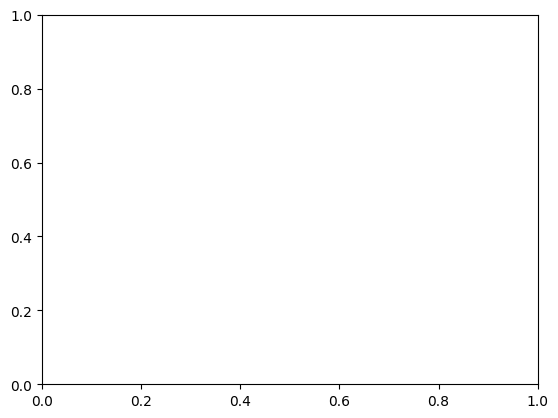

In [14]:

ax = plt.axes()

# Random Goal Babbling
from explauto.interest_model.random import RandomInterest
im_model = RandomInterest(environment.conf, environment.conf.s_dims)

# Reset environment
environment.reset()

# Reset sensorimotor model
from explauto.sensorimotor_model.sensorimotor_model import SensorimotorModel
sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')

# Add points to boostrap sensorimotor model
for i in range(10):
    sm_model.update([0.]*3, [0.]*3)

in_dims = range(3,6)
out_dims = range(3)

for i in range(1000):
    if np.mod(i, context_mode['reset_iterations']) == 0:
        environment.reset()
        
    # Get the context from environment
    context = environment.get_current_context()

    # Draw a goal given this context
    s_g = list(im_model.sample_given_context(context, range(context_mode["context_n_dims"])))
    
    # Infer a motor position to reach this goal given the context
    m = sm_model.infer(in_dims, 
                        out_dims, 
                        context + s_g)
    
    s = environment.update(m, reset=False)
    
    # update the sensorimotor model:
    sm_model.update(m, s)
    # update interest model
    im_model.update(np.hstack((m, context, s_g)), np.hstack((m, s)))
    # plot arm
    environment.plot(ax, alpha=0.1)
    #print "m", m, "s", s, "ds_g", ds_g, "dm", dm
    

Now, let's give a goal to the agent, together with the context of the environment and see if it manages to take into account the context (lazy or not) to do the right motor command.

The goal is [0.95, 0.3], and here the context is normal:

Context: normal
Infered m [ 0.1660466   0.48982339 -0.15758733]
Goal s= [0.95, 0.3] Reached s= [ 1.          0.95064366  0.27254737]


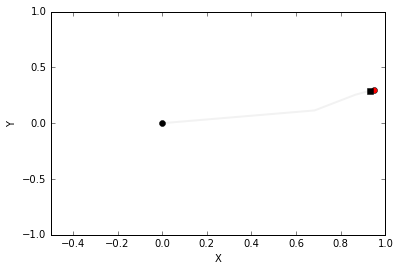

In [62]:
# Inverse with sensory context
ax = axes()

s_g = [0.95, 0.3]
sm_model.mode = "exploit"

context = environment.get_current_context()

print "Context:", "normal" if context[0] else "lazy"

#print "NN", [sm_model.model.inv_model.fwd_model.get_xy(idx) for idx in sm_model.model.inv_model.fwd_model.dataset.nn_y(context+s_g, k=3)[1]]

m = sm_model.infer(in_dims, 
                    out_dims, 
                    context + s_g)
print "Infered m", m

s = environment.update(m, reset=False)

ax.plot(s_g[0], s_g[1], marker='o', color='red')
environment.plot(ax, alpha=0.1)

print "Goal s=", s_g, "Reached s=", s



The same goal in the lazy context:

Context: lazy
Infered m [ 1.04719755  0.71571144  0.38191676]
Goal s= [0.95, 0.3] Reached s= [ 0.          0.9729549   0.09996568]


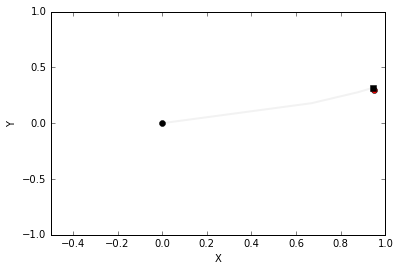

In [63]:
# Inverse with sensory context
ax = axes()

s_g = [0.95, 0.3]
sm_model.mode = "exploit"

context = environment.get_current_context()

print "Context:", "normal" if context[0] else "lazy"

#print "NN", [sm_model.model.inv_model.fwd_model.get_xy(idx) for idx in sm_model.model.inv_model.fwd_model.dataset.nn_y(context+s_g, k=3)[1]]

m = sm_model.infer(in_dims, 
                    out_dims, 
                    context + s_g)
print "Infered m", m

s = environment.update(m, reset=False)

ax.plot(s_g[0], s_g[1], marker='o', color='red')
environment.plot(ax, alpha=0.1)

print "Goal s=", s_g, "Reached s=", s


## Using "Experiment"

Here, the previous loop is entirely encapsulated in the "Experiment" class.

Populating the interactive namespace from numpy and matplotlib


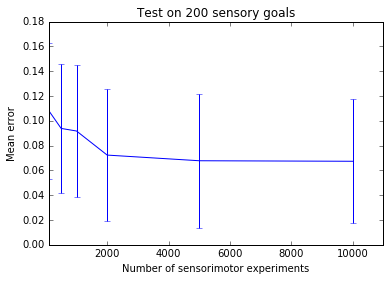

In [65]:
import numpy as np
from explauto import Agent
from explauto import Experiment
from explauto.utils import rand_bounds
from explauto.experiment import make_settings
from explauto.interest_model.interest_model import InterestModel
%pylab inline


context_mode = dict(mode='mcs',
                    rest_position=[0]*3,
                    reset_iterations=10,
                    context_n_dims=1,
                    context_sensory_bounds=[[0],[1]])

sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

agent = Agent(environment.conf, sm_model, im_model, context_mode=context_mode)

expe = Experiment(environment, agent, context_mode)
expe.evaluate_at([100, 500, 1000, 2000, 5000, 10000], 
                 rand_bounds(np.vstack(([0.97, -0.3], [1., 0.3])), n=200))

    
expe.run()

ax = axes()
expe.log.plot_learning_curve(ax)